In [17]:
!pip install tensorflow Pillow numpy matplotlib

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os
import hashlib
from PIL import Image
import numpy as np
import pandas as pd
import pickle

In [19]:
# Directory paths
base_dir = '/content/drive/MyDrive/projects/BoneFracture/dataset'
train_dir = base_dir + '/train'
val_dir = base_dir + '/val'
test_dir = base_dir + '/test'

#EXTRACTING IMAGES into DataFrames

In [20]:
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [21]:
train = data(train_dir)
val = data(val_dir)
test = data(test_dir)


In [22]:
val

,image,label
0,/content/drive/MyDrive/projects/BoneFracture/d...,fractured
1,/content/drive/MyDrive/projects/BoneFracture/d...,fractured
2,/content/drive/MyDrive/projects/BoneFracture/d...,fractured
3,/content/drive/MyDrive/projects/BoneFracture/d...,fractured
4,/content/drive/MyDrive/projects/BoneFracture/d...,fractured
...,...,...
399,/content/drive/MyDrive/projects/BoneFracture/d...,not fractured
400,/content/drive/MyDrive/projects/BoneFracture/d...,not fractured
401,/content/drive/MyDrive/projects/BoneFracture/d...,not fractured
402,/content/drive/MyDrive/projects/BoneFracture/d...,not fractured


#DATA COUNT AND VISUALIZATION

In [23]:
# prompt: distribution of the classes

import os

def count_classes(directory):
  class_counts = {}
  for class_name in os.listdir(directory):
    class_path = os.path.join(directory, class_name)
    if os.path.isdir(class_path):
      class_counts[class_name] = len(os.listdir(class_path))
  return class_counts

train_counts = count_classes(train_dir)
val_counts = count_classes(val_dir)
test_counts = count_classes(test_dir)

print("Training set distribution:", train_counts)
print("Validation set distribution:", val_counts)
print("Test set distribution:", test_counts)

Training set distribution: {'not fractured': 2020, 'fractured': 2079}
Validation set distribution: {'fractured': 169, 'not fractured': 237}
Test set distribution: {'fractured': 200, 'not fractured': 201}


#Image preprocessing

In [24]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator #augumetation resizing and coversion to numpy array
import keras
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_dataframe(
    train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 4097 validated image filenames belonging to 2 classes.
Found 399 validated image filenames belonging to 2 classes.
Found 404 validated image filenames belonging to 2 classes.


#Model Training

In [26]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

###Creating CNN

In [27]:
# Bone Fracture Detection CNN Training and Fine-Tuning
image_size = (224, 224)
img_height, img_width = image_size

def create_cnn_model(img_height, img_width):
    """
    Create the CNN model architecture

    Args:
        img_height (int): Height of input images
        img_width (int): Width of input images

    Returns:
        Sequential: Compiled CNN model
    """
    cnn_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return cnn_model

### Training and Saving model

In [28]:
# First Training Phase (Initial Training)
def initial_training(cnn_model, train_generator, val_generator):
    """
    Perform initial training of the CNN model

    Args:
        cnn_model (Sequential): CNN model
        train_generator : Training data generator
        val_generator : Validation data generator

    Returns:
        History: Training history
    """
    # Callbacks for initial training
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Checkpoint to save the best initial model
    checkpoint = ModelCheckpoint(
        '/content/drive/MyDrive/projects/BoneFracture/weights/CNN_baseline_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,  # Saves both weights and architecture
        mode='min',
        verbose=1
    )

    # Compile the model
    cnn_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Train the initial model
    initial_history = cnn_model.fit(
        train_generator,
        epochs=15,
        validation_data=val_generator,
        steps_per_epoch=len(train_generator),
        validation_steps=len(val_generator),
        callbacks=[early_stopping, checkpoint]
    )

    return initial_history

# Fine-Tuning Phase
def fine_tune_model(cnn_model, train_generator, val_generator):
    """
    Fine-tune the trained CNN model

    Args:
        cnn_model (Sequential): Trained CNN model
        train_generator : Training data generator
        val_generator: Validation data generator

    Returns:
        History: Fine-tuning training history
    """
    # Checkpoint for fine-tuned model
    fine_tuned_checkpoint = ModelCheckpoint(
        '/content/drive/MyDrive/projects/BoneFracture/weights/cnn_fine_tuned_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    )

    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Make some layers trainable for fine-tuning
    for layer in cnn_model.layers:
        if isinstance(layer, (Conv2D, Dense)):
            layer.trainable = True

    # Recompile with lower learning rate for fine-tuning
    cnn_model.compile(
        optimizer=Adam(learning_rate=0.00001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Fine-tune the model
    fine_tuned_history = cnn_model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator,
        callbacks=[fine_tuned_checkpoint, early_stopping]
    )

    return fine_tuned_history

# Main execution (example usage)
def main(img_height, img_width, train_generator, val_generator):
    # Create the model
    cnn_model = create_cnn_model(img_height, img_width)

    # Initial training
    initial_history = initial_training(cnn_model, train_generator, val_generator)

    # Fine-tuning
    fine_tuned_history = fine_tune_model(cnn_model, train_generator, val_generator)

     # Save the training history using pickle
    with open('/content/drive/MyDrive/projects/BoneFracture/histories/cnn_fine_tuned_history.pkl', 'wb') as file:
        pickle.dump(fine_tuned_history.history, file)

    # Verify if saved correctly
    print("Training history saved successfully!")

if __name__ == '__main__':
    main(img_height=224, img_width=224, train_generator=train_generator, val_generator=val_generator)

# Later: Load the history
with open('/content/drive/MyDrive/projects/BoneFracture/histories/cnn_fine_tuned_history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)
    print("Loaded history:", loaded_history)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7624 - loss: 0.7300
Epoch 1: val_loss improved from inf to 3.60199, saving model to /content/drive/MyDrive/projects/BoneFracture/weights/CNN_baseline_model.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 1044s 8s/step - accuracy: 0.7629 - loss: 0.7278 - val_accuracy: 0.4158 - val_loss: 3.6020
Epoch 2/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/15


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9273 - loss: 0.1967
Epoch 3: val_loss did not improve from 3.60199
129/129 ━━━━━━━━━━━━━━━━━━━━ 943s 7s/step - accuracy: 0.9273 - loss: 0.1966 - val_accuracy: 0.4158 - val_loss: 5.0310
Epoch 4/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9640 - loss: 0.1136
Epoch 5: val_loss improved from 3.60199 to 2.91349, saving model to /content/drive/MyDrive/projects/BoneFracture/weights/CNN_baseline_model.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 957s 7s/step - accuracy: 0.9641 - loss: 0.1136 - val_accuracy: 0.5396 - val_loss: 2.9135
Epoch 6/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/15
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9803 - loss: 0.0755
Epoch 7: val_loss improved from 2.91349 to 1.73783, saving model to /content/drive/MyDrive/projects/BoneFracture/weights/CNN_baseline_

###Load and save as h5

In [29]:
import tensorflow as tf
model= tf.keras.models.load_model('/content/drive/MyDrive/projects/BoneFracture/weights/cnn_fine_tuned_model.keras')
#model.save('/content/drive/MyDrive/projects/BoneFracture/weights/cnn_fine_tuned_model.h5')

###Model Evaluation

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

# Predictions and metrics for the test set
test_preds = model.predict(test_generator)
test_preds = (test_preds > 0.5).astype(int)
test_labels = test_generator.classes

print('Classification Report')
print(classification_report(test_labels, test_preds, target_names=test_generator.class_indices.keys()))

print('Confusion Matrix')
print(confusion_matrix(test_labels, test_preds))

accuracy = accuracy_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)

print(f'Accuracy: {accuracy}')
print(f'F1 score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.6373 - loss: 3.2820
Test loss: 2.1405043601989746
Test accuracy: 0.7518796920776367
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step
Classification Report
               precision    recall  f1-score   support

    fractured       0.90      0.57      0.70       199
not fractured       0.68      0.94      0.79       200

     accuracy                           0.75       399
    macro avg       0.79      0.75      0.74       399
 weighted avg       0.79      0.75      0.74       399

Confusion Matrix
[[113  86]
 [ 13 187]]
Accuracy: 0.7518796992481203
F1 score: 0.7906976744186046
Precision: 0.684981684981685
Recall: 0.935


###Plotting losses and accuracies

In [31]:
import pickle
# Later: Load the history
with open('/content/drive/MyDrive/projects/BoneFracture/histories/cnn_fine_tuned_history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)
    print("Loaded history:", loaded_history)

Loaded history: {'accuracy': [0.9965828657150269, 0.9987795948982239, 0.9990236759185791, 0.9997559189796448, 0.997803270816803, 0.9990236759185791], 'loss': [0.018566248938441277, 0.012718257494270802, 0.010951712727546692, 0.00808949489146471, 0.011736090295016766, 0.008819461800158024], 'val_accuracy': [0.7920792102813721, 0.7871286869049072, 0.7797029614448547, 0.7846534848213196, 0.7673267126083374, 0.7648515105247498], 'val_loss': [1.560349464416504, 1.8734121322631836, 1.9753879308700562, 1.8726799488067627, 1.9506175518035889, 2.0584113597869873]}


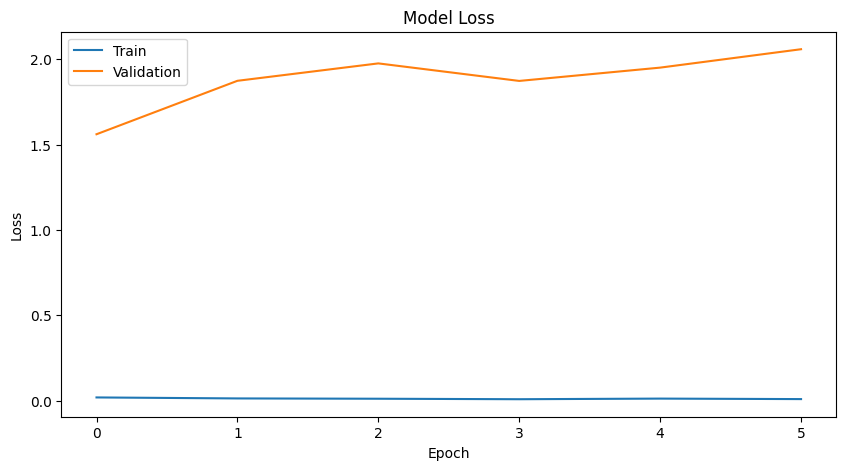

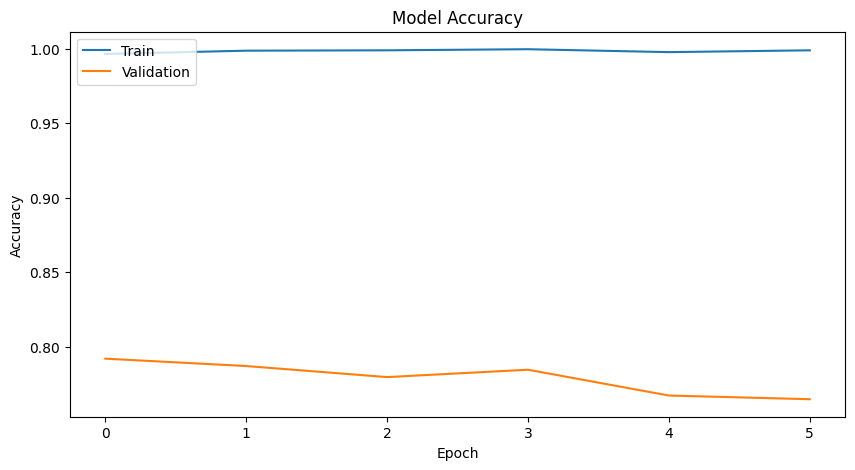

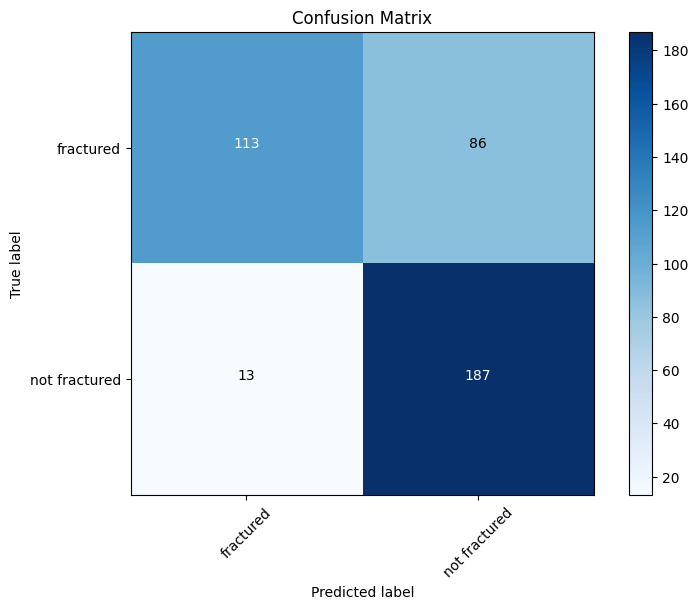

In [32]:
# prompt: visualize the metrics

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

import numpy as np
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
